<a href="https://colab.research.google.com/github/devanshjoshi104/Andrej-YT-Lecture/blob/main/Lecture3_makemore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import random

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-12-30 08:19:39--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2024-12-30 08:19:39 (6.19 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [86]:
# params
sample_data_size = len(words)
# sample_data_size = 5
embedding_dim_size = 10
unique_objects_count = 27
block_size = 3

In [62]:
def build_dataset(words):
  X, Y = [], []


  for w in words[:sample_data_size]:
      context = [0] * block_size
      for ch in w + '.':
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
          # print(''.join(itos[i] for i in context), '--->', itos[ix])
          context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y


In [59]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X,Y = build_dataset(words[:n1])
Xval,Yval = build_dataset(words[n1:n2])
Xtest,Ytest = build_dataset(words[n2:])


In [93]:
C = torch.randn((unique_objects_count, embedding_dim_size))

In [7]:
C[5]
# this is equal to if we create one hot embedding of 5 and do one hot @ C

tensor([-1.9790, -1.3174])

In [91]:
emb = C[X]
emb.shape

torch.Size([182625, 3, 10])

In [9]:
#  Neural Net
#  block_size * embedding_dim_size, if will be passing 3 words and 2 is dimension in which word is represented, then neural input will be 6
neural_net_nodes = 300
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((block_size * embedding_dim_size, neural_net_nodes), generator=g, requires_grad = True)
b1 = torch.randn(neural_net_nodes, generator=g, requires_grad = True)

we need to do emb @ W
but size of emb is 3*2
and of W is 6*100
so we need to concatenate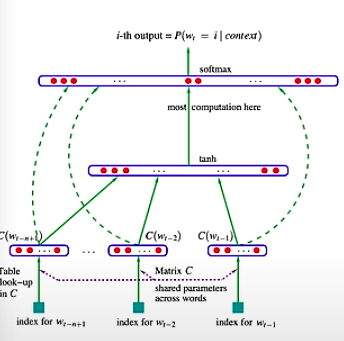 to match shape

In [10]:
# torch.concat(torch.unbind(emb, 1), 1)

In [11]:
# can use view as that is what we wants to achiev
# emb.view(len(X), block_size * embedding_dim_size) == torch.concat(torch.unbind(emb, 1), 1)

In [12]:
# forward pass
h = emb.view(-1, block_size * embedding_dim_size) @ W1 + b1
h.shape

torch.Size([228146, 100])

In [13]:
# second layer
W2 = torch.randn((neural_net_nodes, unique_objects_count), generator=g, requires_grad = True)
b2 = torch.randn(unique_objects_count, generator=g, requires_grad = True)

In [14]:
# forward pass
logits = h @ W2 + b2
count = logits.exp()
prob = count/ count.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [15]:
loss = -prob[torch.arange(len(Y)), Y].log().mean()
loss

tensor(nan, grad_fn=<NegBackward0>)

Refactored Code


In [94]:
neural_net_nodes = 300
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((block_size * embedding_dim_size, neural_net_nodes), generator=g, requires_grad = True)
b1 = torch.randn(neural_net_nodes, generator=g, requires_grad = True)
W2 = torch.randn((neural_net_nodes, unique_objects_count), generator=g, requires_grad = True)
b2 = torch.randn(unique_objects_count, generator=g, requires_grad = True)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

17697

In [95]:
for p in parameters:
  p.requires_grad = True

In [96]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [104]:
lr_used = []
lr_loss = []
stepi = []
for k in range(30000):
  # batching
  batch_size = 32
  ix = torch.randint(0, X.shape[0], (batch_size,))
  # forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, block_size * embedding_dim_size) @ W1 + b1)
  logits = h @ W2 + b2
  # count = logits.exp()
  # prob = count/ count.sum(1, keepdims=True)
  # loss = -prob[torch.arange(len(Y)), Y].log().mean()
  loss = F.cross_entropy(logits, Y[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # lr = lrs[k]
  lr = 0.01
  # update
  for p in parameters:
    p.data += -lr * p.grad
  # print(k, loss.item())

  # track stats
  # lr_used.append(lr)
  lr_loss.append(loss.item())
  stepi.append(k)
print(loss.item())

2.0632669925689697


In [ ]:
# plt.plot(lr_used, lr_loss)
# apply elbow method in graph

In [107]:
emb = C[X]
h = torch.tanh(emb.view(-1, block_size * embedding_dim_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss)

tensor(2.1694, grad_fn=<NllLossBackward0>)


In [105]:
emb = C[Xval]
h = torch.tanh(emb.view(-1, block_size * embedding_dim_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
print(loss)

tensor(2.1972, grad_fn=<NllLossBackward0>)


In [106]:
emb = C[Xtest]
h = torch.tanh(emb.view(-1, block_size * embedding_dim_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytest)
print(loss)

tensor(2.2063, grad_fn=<NllLossBackward0>)


If loss_val == loss_training -> underfitting
if loss_val >> loss_training -> overfitting

In [108]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
kmynn.
see.
med.
ryla.
reishareks.
leg.
aderedielin.
shi.
jen.
edelieananarleilyn.
honelin.
shrunziehimier.
kin.
renelionnie.
conu.
zened.
ryyah.
faehs.
kayshistoula.
